In [55]:
import sys
sys.path.append('../src/')
import time
import os
import copy

import numpy as np
import tensorly as tn
import matlab.engine
import matplotlib.pyplot as plt

from loewnerize_acts import loewnerize_acts
import ll1_tools

## Load raw data for LenetLinear classifier model

In [2]:
targets_path = '../data/LenetLinear/activations/test/targets.npy'
targets = np.load(targets_path)

inputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.linear.npy'
inputs_raw = np.load(inputs_path)
print('Inputs shape')
print(inputs_raw.shape)

outputs_path = '../data/LenetLinear/activations/test/99/layers.layer_0.rat.npy'
outputs_raw = np.load(outputs_path)
print('Outputs shape')
print(outputs_raw.shape)
print(outputs_raw[0,0,0])

# tensorlab_path = '~/ware/matlab_tools/tensorlab'
tensorlab_path = '~/tools/matlab_tools/Tensorlab'

Inputs shape
(39, 256, 10)
Outputs shape
(39, 256, 10)
-5.9573436


In [42]:
# isolate observation matrices (X in BSS problem)
tmp_obs = outputs_raw.reshape(-1, outputs_raw.shape[-1])
print(f"obs: {tmp_obs.shape}, targets: {targets.shape}")

obs_0 = []
obs_1 = []
obs_2 = []
obs_3 = []
obs_4 = []
obs_5 = []
obs_6 = []
obs_7 = []
obs_8 = []
obs_9 = []
obs = [obs_0, obs_1, obs_2, obs_3, obs_4, obs_5, obs_6, obs_7, obs_8, obs_9]

for idx, trgt in enumerate(targets):
    obs[trgt].append(tmp_obs[idx])

for idx, ob in enumerate(obs):
    obs[idx] = np.array(ob)

print(obs[1].shape)
print(tmp_obs[0].shape)

obs: (9984, 10), targets: (9984,)
(1133, 10)
(10,)


In [3]:
lwn_tensors = loewnerize_acts(inputs_raw, outputs_raw, targets, tensorlab_path)
# datapath = '../data/LenetLinear/activations/test/99/loewnerized_acts'
# np.savez(datapath, *lwn_tensors)

In [43]:
# for lwn_trgt in lwn_tensors:
#     print(lwn_trgt.shape)
#     print(type(lwn_trgt))

## perform (L,L,1) decomposition - per target (0-9)

In [5]:
eng = matlab.engine.start_matlab()
s = eng.genpath(tensorlab_path)
eng.addpath(s, nargout=0)

num_terms = 25
rat_deg = 3

L = rat_deg * np.ones(num_terms)
Us = list()
outs = list()

tic = time.perf_counter()
for tns in lwn_tensors:
    tmp_U, tmp_out = eng.ll1(tns, L, nargout=2)
    Us.append(tmp_U)
    outs.append(tmp_out)
toc = time.perf_counter()
print(toc-tic)

> In ll1_core/state (line 238)
In ll1_core (line 191)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll

In [47]:
# recover sources
sources = list()
mixes = list()
for idx, model in enumerate(Us):
    tmp = ll1_tools.pack_ll1(model)
    mix = tmp[2]
    mixes.append(mix)
    src = ll1_tools.recover_sources(obs[idx], mix)
    sources.append(src)

svds = []
for src in sources:
    svds.append(np.linalg.svd(src))

print(len(svds[0]))

3


[5.99469193e-14 6.38710421e-14 0.00000000e+00 6.19503476e-14
 5.93727595e-14 6.17285000e-14 6.05678890e-14 6.06855391e-14
 6.08844635e-14 6.07180321e-14]


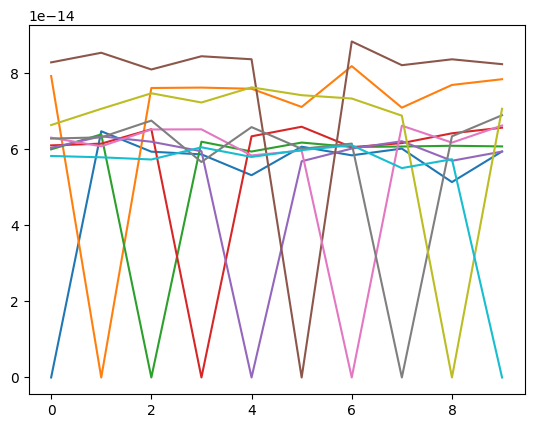

In [57]:
angles = np.zeros((len(svds), len(svds)))
for i in range(len(svds)):
    for j in range(len(svds)):
        if i != j:
            angles[i,j] = eng.rad2deg(eng.subspace(svds[i][0], svds[j][0]))

print(angles[2])
for i in range(len(svds)):
    plt.plot(angles[i])

In [58]:
plt.heatmap(angles)

AttributeError: module 'matplotlib.pyplot' has no attribute 'heatmap'

## perform (L,L,1) decomposition - entire collection

In [8]:
super_lwn = lwn_tensors[0]
print(type(super_lwn))
for i in range(9):
    super_lwn = np.dstack((super_lwn, lwn_tensors[i+1]))

# shuffle
np.random.shuffle(super_lwn)
print(super_lwn.shape)

super_lwn_1 = np.array(super_lwn[:,:,:(9984//2)])
super_lwn_2 = np.array(super_lwn[:,:,(9984//2):])

print(super_lwn_1.shape)
print(super_lwn_2.shape)


<class 'numpy.ndarray'>
(5, 5, 9984)
(5, 5, 4992)
(5, 5, 4992)


In [9]:
num_terms = 25
rat_deg = 3
L = rat_deg * np.ones(num_terms)

tic = time.perf_counter()
all_U_1, all_out_1 = eng.ll1(super_lwn_1, L, nargout=2)
all_U_2, all_out_2 = eng.ll1(super_lwn_2, L, nargout=2)

toc = time.perf_counter()
print(toc-tic)

> In ll1_core/state (line 238)
In ll1_core (line 191)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll1_core/grad (line 256)
In nls_gndl (line 369)
In ll1_core (line 193)
In ll1_nls (line 40)
In ll1 (line 551)

> In ll1_core/state (line 238)
In ll

In [17]:
res_1 = 1 - eng.frobll1res(super_lwn_1,all_U_1) / eng.frob(super_lwn_1)
print(f"Residual_1: {res_1}")
res_2 = 1 - eng.frobll1res(super_lwn_2,all_U_2) / eng.frob(super_lwn_2)
print(f"Residual_2: {res_2}")

Residual_1: 0.9999989875639654
Residual_2: 0.9999974078605245


In [18]:
print("time to party")


time to party
